Feature matrix shape: (1000, 20)
Target matrix shape: (1000, 5)
Sample 0 features:
 [3. 0. 2. 2. 2. 8. 3. 2. 5. 2. 0. 1. 0. 1. 0. 0. 6. 5. 0. 2.]
Sample 0 labels:
 [0 0 0 1 0]
Epoch    0 | train_loss=0.7086 | test_loss=0.7003 | F1µ=0.548 | F1M=0.536 | Hamming=0.623 | SubsetAcc=0.035
Epoch    1 | train_loss=0.7031 | test_loss=0.6937 | F1µ=0.548 | F1M=0.536 | Hamming=0.623 | SubsetAcc=0.035
Epoch  100 | train_loss=0.4152 | test_loss=0.4007 | F1µ=0.749 | F1M=0.704 | Hamming=0.181 | SubsetAcc=0.435
Epoch  200 | train_loss=0.3770 | test_loss=0.3684 | F1µ=0.786 | F1M=0.757 | Hamming=0.154 | SubsetAcc=0.525
Epoch  300 | train_loss=0.3414 | test_loss=0.3553 | F1µ=0.798 | F1M=0.769 | Hamming=0.146 | SubsetAcc=0.545
Epoch  400 | train_loss=0.3197 | test_loss=0.3528 | F1µ=0.793 | F1M=0.764 | Hamming=0.149 | SubsetAcc=0.540
Epoch  500 | train_loss=0.3092 | test_loss=0.3545 | F1µ=0.787 | F1M=0.758 | Hamming=0.153 | SubsetAcc=0.560
Epoch  600 | train_loss=0.3022 | test_loss=0.3566 | F1µ=0.786 | F1M=

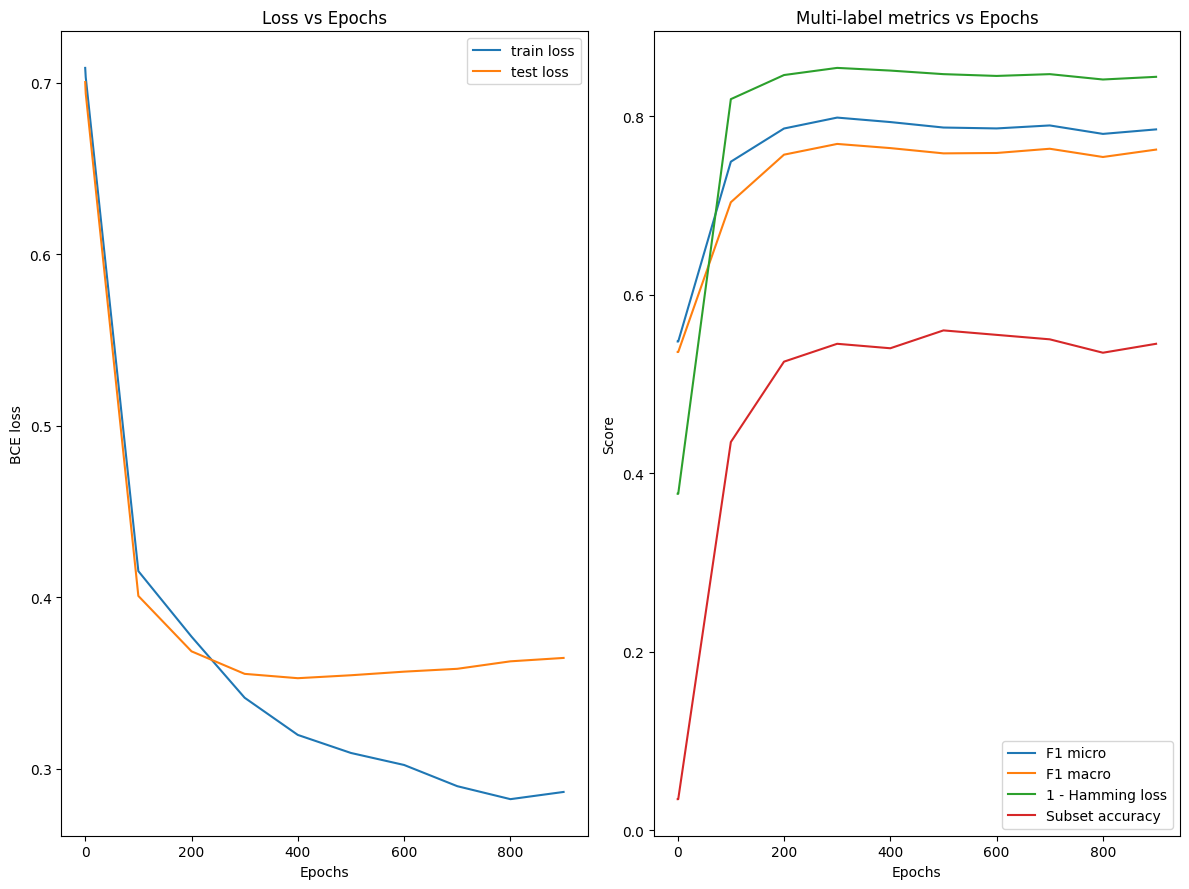

In [117]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
import numpy as np


X, y = make_multilabel_classification(
    n_samples=1000,
    n_features=20,
    n_classes=5,
    n_labels=2,
    random_state=42
)

print("Feature matrix shape:", X.shape)   # (1000, 20)
print("Target matrix shape:", y.shape)    # (1000, 5)

# Check one sample
print("Sample 0 features:\n", X[0])
print("Sample 0 labels:\n", y[0])

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

device = "cuda" if torch.cuda.is_available() else "cpu"

X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.float32).to(device)


class multiLabelClassifier(nn.Module):
    def __init__(self, in_dims, out_dims, hidden_1=126, hidden_2=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dims, hidden_1),nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(hidden_1, hidden_2), nn.ReLU(),nn.Dropout(0.5),
            nn.Linear(hidden_2, out_dims)
        )

    def forward(self, x):
        return self.net(x)


model = multiLabelClassifier(in_dims=len(X_train[0]), out_dims=len(y_train[0])).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

# Training
EPOCHS = 1000
PRINT_EVERY = 100
epoch_count = []
f1_micro_hist, f1_macro_hist, hamming_hist, subset_acc_hist = [], [], [], []
training_loss, testing_loss = [], []

THRESHOLD = 0.4
for epoch in range(EPOCHS):
    model.train()
    logits = model(X_train)
    y_pred = (torch.sigmoid(logits).detach().numpy() >= THRESHOLD).astype(int)
    loss = loss_fn(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        y_test_pred = (torch.sigmoid(test_logits).cpu().numpy() >= THRESHOLD).astype(int)
        test_loss = loss_fn(test_logits, y_test)

    if epoch % PRINT_EVERY == 0 or epoch == 1 or epoch == EPOCHS:
        # metrics
        f1_micro = f1_score(y_test, y_test_pred, average="micro", zero_division=0)
        f1_macro = f1_score(y_test, y_test_pred, average="macro", zero_division=0)
        hamming  = hamming_loss(y_test, y_test_pred)
        subset   = accuracy_score(y_test, y_test_pred)  # exact match

        epoch_count.append(epoch)
        training_loss.append(loss.item())
        testing_loss.append(test_loss.item())

        f1_micro_hist.append(f1_micro)
        f1_macro_hist.append(f1_macro)
        hamming_hist.append(hamming)
        subset_acc_hist.append(subset)
        print(f"Epoch {epoch:4d} | train_loss={loss:.4f} | test_loss={test_loss:.4f} "
              f"| F1µ={f1_micro:.3f} | F1M={f1_macro:.3f} | Hamming={hamming:.3f} | SubsetAcc={subset:.3f}")

# Final Evaluation
model.eval()
with torch.inference_mode():
    logits = model(X_test)
    y_pred = (torch.sigmoid(logits).cpu().numpy() >= THRESHOLD).astype(int)
    test_loss = loss_fn(logits, y_test)
    f1_micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    hamming  = hamming_loss(y_test, y_pred)
    subset   = accuracy_score(y_test, y_pred)  # exact match
    print(f"Final Evaluation | test_loss={test_loss:.4f} | F1µ={f1_micro:.3f} | F1M={f1_macro:.3f} | Hamming={hamming:.3f} | Subset={subset:.3f}")
#   What your numbers say
# F1 (micro) ~ 0.79, F1 (macro) ~ 0.77 → solid.
print(f"F1µ={f1_micro:.3f} ~ 0.77 → solid.")
# Hamming ≈ 0.146 → per-label accuracy ≈ 1 − 0.146 = 0.854 (nice).
print(f"Hamming ≈ {hamming:.3f} → per-label accuracy ≈ 1 − {hamming:.3f} = {1-hamming:.3f} (nice).")
# Subset accuracy ~ 0.56 → this is strict (exact match across all 5 labels), so 0.56 is actually quite good.
print(f"Subset accuracy ~ {subset:.3f} → this is strict (exact match across all 5 labels), so {subset:.3f} is actually quite good.")


# --- Plots
plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.plot(epoch_count, training_loss, label="train loss")
plt.plot(epoch_count, testing_loss, label="test loss")
plt.xlabel("Epochs"); plt.ylabel("BCE loss");
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_count, f1_micro_hist, label="F1 micro")
plt.plot(epoch_count, f1_macro_hist, label="F1 macro")
plt.plot(epoch_count, [1-h for h in hamming_hist], label="1 - Hamming loss")
plt.plot(epoch_count, subset_acc_hist, label="Subset accuracy")
plt.xlabel("Epochs");
plt.ylabel("Score");
plt.title("Multi-label metrics vs Epochs")
plt.legend()
plt.tight_layout()
plt.show()